In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
import torch
import torchvision

Dataset size: 5160
Image Format: TIFF
Image Mode: L
Image Size: (39, 105)
Label:  و


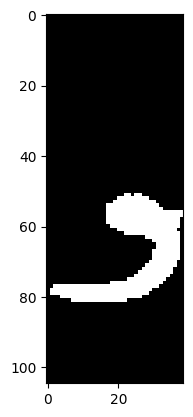

In [3]:
# Open the TIFF image
DATASET_IMAGES_PATH = "Dataset/Total Images/"
DATASET_LETTERS_PATH = "Dataset/Total GT/"

images = os.listdir(DATASET_IMAGES_PATH)

image_path = random.choice(images)

label_file = image_path.removesuffix(".tif")+".txt"
with open(os.path.join(DATASET_LETTERS_PATH, label_file), 'r') as lf:
    label = lf.read()

image = Image.open(os.path.join(DATASET_IMAGES_PATH, image_path))

# Display some basic information about the image
print("Dataset size:", len(images))
print("Image Format:", image.format)
print("Image Mode:", image.mode)
print("Image Size:", image.size)
print("Label: ", label)

image_array = np.array(image)

plt.imshow(image_array, cmap="gray");


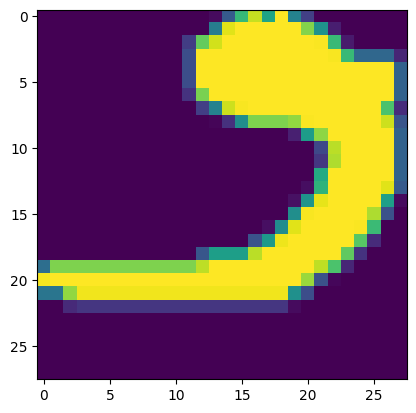

In [4]:
def find_size(numbers):
    first_non_zero_index = None
    last_non_zero_index = None

    for i, num in enumerate(numbers):
        if num != 0:
            if first_non_zero_index is None:
                first_non_zero_index = i
            last_non_zero_index = i

    # Check if any non-zero element found
    if first_non_zero_index is not None:
        size = last_non_zero_index - first_non_zero_index
    else:
        # If no non-zero elements found, set size to 0
        size = 0

    return {"start": first_non_zero_index,
            "end": last_non_zero_index,
            "size": size}


def square_crop(image, resize):
    # Find largest dimension vertical and horizontal
    v_dim = find_size(image.sum(axis=1))
    h_dim = find_size(image.sum(axis=0))
    
    # Create new image with largest dimension
    if h_dim["size"]>v_dim["size"]:
        cropped_image = torch.zeros(h_dim["size"]+1,h_dim["size"]+1)
    else:
        cropped_image = torch.zeros(v_dim["size"]+1,v_dim["size"]+1)

    # Cut the image and put it in the new cropped image then resize
    cropped_image[:v_dim["size"], :h_dim["size"]] = torch.Tensor(image[v_dim["start"]:v_dim["end"], h_dim["start"]:h_dim["end"]])
    cropped_image = resize(cropped_image[None,...])

    return cropped_image[0]

resize = torchvision.transforms.Resize((28,28))
cropped = square_crop(image_array, resize)
plt.imshow(cropped)

In [34]:
def get_unique_targets(labels_folder):
    unique_targets = set()

    for filename in os.listdir(labels_folder):
        label_path = os.path.join(labels_folder, filename)
        with open(label_path, 'r') as f:
            target = f.read()
            unique_targets.add(target.strip())

    return list(unique_targets)

def decode_target(id, unique_targets):
    return unique_targets[id]

In [115]:
import os
import cv2
from torch.utils.data import Dataset
import torchvision.transforms as transforms

# Define the transformation to resize images to 28x28
resize = transforms.Resize((64,64))

class CustomDataset(Dataset):
    def __init__(self, images_folder, labels_folder, transform=None):
        self.images_folder = images_folder
        self.labels_folder = labels_folder
        self.image_names = os.listdir(images_folder)
        self.transform = transform
        self.unique_targets = get_unique_targets(labels_folder)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.images_folder, image_name)
        label_path = os.path.join(self.labels_folder, image_name.split(".")[0]+".txt")
        
        # Read the label
        with open(label_path, 'r') as f:
            label = f.read()

        # Read image using OpenCV
        image_array = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        # Apply square crop and resize transformation
        image_tensor = square_crop(image_array, self.transform)
        
        # Normalize image pixel values
        image_tensor /= 255.0
        
        # Add channel dimension for grayscale image
        image_tensor = image_tensor.unsqueeze(0)

        return (image_tensor, self.unique_targets.index(label.strip()))

# Create an instance of CustomDataset
custom_dataset = CustomDataset(images_folder=DATASET_IMAGES_PATH,
                               labels_folder=DATASET_LETTERS_PATH,
                               transform=resize)

# Example usage of the custom dataset
for i in range(3):
    data = custom_dataset[i]
    print(data[0].shape)
    print(data[1])


torch.Size([1, 64, 64])
205
torch.Size([1, 64, 64])
6
torch.Size([1, 64, 64])
134


In [116]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

# Define the sizes for train, validation, and test sets
train_size = int(0.7 * len(custom_dataset))  # 70% of the data for training
val_size = int(0.15 * len(custom_dataset))   # 15% of the data for validation
test_size = len(custom_dataset) - train_size - val_size  # Remaining data for testing

# Use random_split to split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(custom_dataset, [train_size, val_size, test_size])

# Example usage:
print("Train set size:", len(train_dataset))
print("Validation set size:", len(val_dataset))
print("Test set size:", len(test_dataset))

# Define batch size for train, validation, and test DataLoader instances
batch_size_train = 32
batch_size_val = 32
batch_size_test = 32

# Create DataLoader instances for train, validation, and test datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

# Example usage:
print("Number of batches in train loader:", len(train_loader))
print("Number of batches in validation loader:", len(val_loader))
print("Number of batches in test loader:", len(test_loader))


Train set size: 3611
Validation set size: 774
Test set size: 775
Number of batches in train loader: 113
Number of batches in validation loader: 25
Number of batches in test loader: 25


In [118]:
import torch.nn as nn
import torch.optim as optim

num_classes = len(custom_dataset.unique_targets)

# Step 1: Prepare your dataset
# Assuming you have a dataset object named 'dataset' containing your images and labels

# Step 2: Define your model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 8 * 8, num_classes),
            nn.Sigmoid()
            ) # Adjust input size according to your image size

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Step 3: Set up your training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN(num_classes).to(device)  # Assuming you have 10 classes
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 4: Train your model
num_epochs = 50

for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Step 5: Evaluate your model
# You can evaluate your model on a separate validation set similarly to training loop

# Save the trained model
torch.save(model.state_dict(), 'cnn_model.pth')


Epoch [1/50], Step [100/113], Loss: 5.3364
Epoch [2/50], Step [100/113], Loss: 5.1641
Epoch [3/50], Step [100/113], Loss: 5.2234
Epoch [4/50], Step [100/113], Loss: 5.1942
Epoch [5/50], Step [100/113], Loss: 5.0261
Epoch [6/50], Step [100/113], Loss: 5.0353
Epoch [7/50], Step [100/113], Loss: 5.1629
Epoch [8/50], Step [100/113], Loss: 4.9865
Epoch [9/50], Step [100/113], Loss: 4.9809
Epoch [10/50], Step [100/113], Loss: 5.2077
Epoch [11/50], Step [100/113], Loss: 5.0822
Epoch [12/50], Step [100/113], Loss: 5.1134
Epoch [13/50], Step [100/113], Loss: 5.0147
Epoch [14/50], Step [100/113], Loss: 4.9581
Epoch [15/50], Step [100/113], Loss: 5.0414
Epoch [16/50], Step [100/113], Loss: 4.9789
Epoch [17/50], Step [100/113], Loss: 4.9759
Epoch [18/50], Step [100/113], Loss: 5.0716
Epoch [19/50], Step [100/113], Loss: 4.9763
Epoch [20/50], Step [100/113], Loss: 5.0951
Epoch [21/50], Step [100/113], Loss: 5.0046
Epoch [22/50], Step [100/113], Loss: 5.1246
Epoch [23/50], Step [100/113], Loss: 5.03

Dataset size: 5160
Image Format: TIFF
Image Mode: L
Image Size: (117, 172)
Label:  أت
Predicted label:  ك


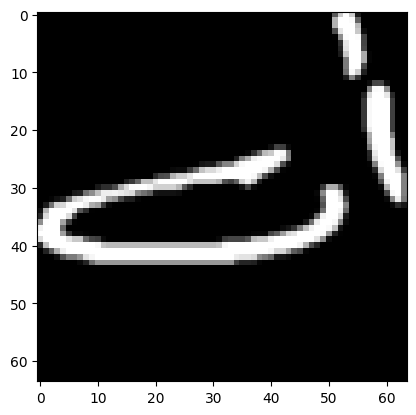

In [173]:
def try_model(model,
              images_path=DATASET_IMAGES_PATH,
              labels_path=DATASET_LETTERS_PATH):

    images = os.listdir(DATASET_IMAGES_PATH)

    image_path = random.choice(images)

    label_file = image_path.removesuffix(".tif")+".txt"
    with open(os.path.join(DATASET_LETTERS_PATH, label_file), 'r') as lf:
        label = lf.read()

    image = Image.open(os.path.join(DATASET_IMAGES_PATH, image_path))

    # Display some basic information about the image
    print("Dataset size:", len(images))
    print("Image Format:", image.format)
    print("Image Mode:", image.mode)
    print("Image Size:", image.size)
    print("Label: ", label)

    image_array = square_crop(np.array(image),resize)

    x = torch.as_tensor(image_array).unsqueeze(0).unsqueeze(0).to(device)
    pred = torch.argmax(model(x))
    print("Predicted label: ", decode_target(pred, custom_dataset.unique_targets))

    plt.imshow(image_array, cmap="gray");

try_model(model)
